In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.55_.7_.9',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.55_.7_.9',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 294.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.55, .7, .9/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 5e-25

include 'mls75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

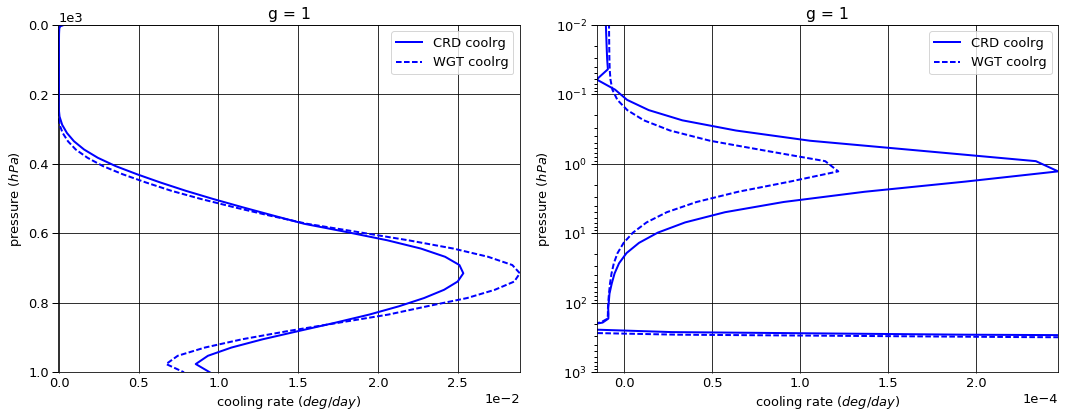

# Figure: cooling rate g-group 2

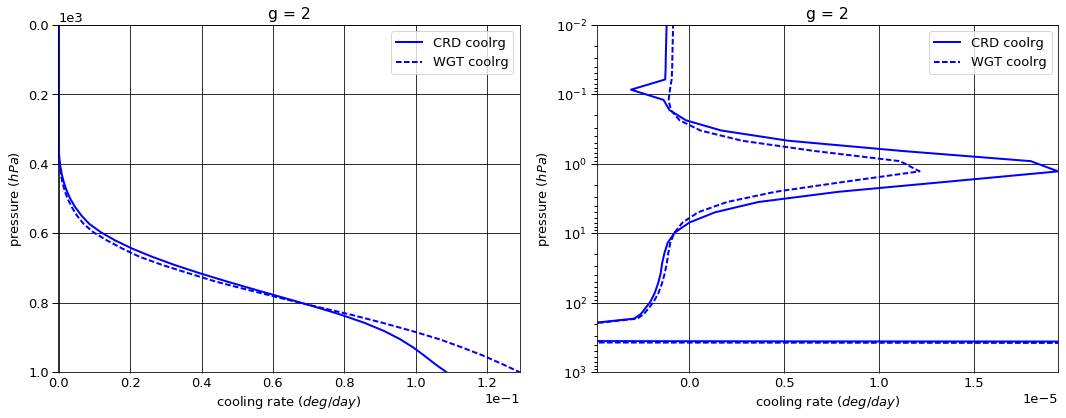

# Figure: cooling rate g-group 3

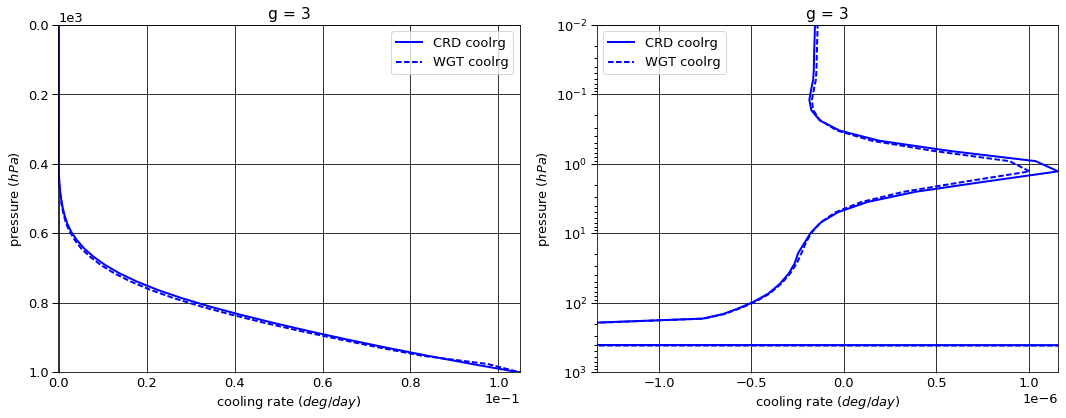

# Figure: cooling rate g-group total

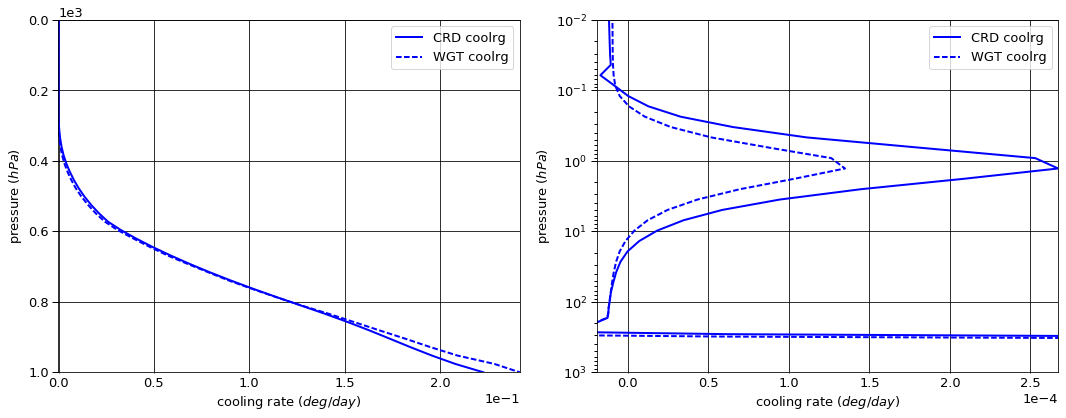

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -1.229739  0.000000  -1.229739
  1013.0   76     -1.664999  1.591366  -0.073633
2 0.0      1      -7.557591  0.000000  -7.557591
  1013.0   76     -8.086065  3.846347  -4.239718
3 0.0      1     -51.704334  0.000000 -51.704334
  1013.0   76    -51.930183  2.259516 -49.670667


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -1.224900  0.000000  -1.224900
  1013.0   76     -1.664999  1.625220  -0.039779
2 0.0      1      -7.575491  0.000000  -7.575491
  1013.0   76     -8.086065  4.016268  -4.069797
3 0.0      1     -51.714017  0.000000 -51.714017
  1013.0   76    -51.930183  2.198189 -49.731994


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.004839  0.000000  0.004839
  1013.0   76     0.000000  0.033854  0.033854
2 0.0      1     -0.017900  0.000000 -0.017900
  1013.0   76     0.000000  0.169921  0.169921
3 0.0      1     -0.009683  0.000000 -0.009683
  1013.0   76     0.000000 -0.061327 -0.061327

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.142514e-05
  1001.112500 75     9.457120e-03
2 0.000312    1     -1.083952e-06
  1001.112500 75     1.086679e-01
3 0.000312    1     -1.421765e-07
  1001.112500 75     1.046451e-01


WGT


coolrg
g pressure    layer              
1 0.000312    1     -8.739179e-06
  1001.112500 75     7.837183e-03
2 0.000312    1     -7.605723e-07
  1001.112500 75     1.291897e-01
3 0.000312    1     -1.286313e-07
  1001.112500 75     1.048603e-01


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.685965e-06
  1001.112500 75    -1.619937e-03
2 0.000312    1      3.233795e-07
  1001.112500 75     2.052182e-02
3 0.000312    1      1.354520e-08
  1001.112500 75     2.151600e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.491664,0.000000,-60.491664
1013.0,76,-61.681246,7.697229,-53.984018



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.514408,0.000000,-60.514408
1013.0,76,-61.681246,7.839677,-53.841569



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.022744,0.000000,-0.022744
1013.0,76,0.000000,0.142448,0.142449


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.222770



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000010
1001.112500,75,0.241887



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000003
1001.112500,75,0.019117


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.025750,0.027658
2,0.128833,0.132364
3,0.845417,0.839979


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,8.423988e-24
2,5.000223e-25
3,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,8.423988e-24,NaN,0.025750,0.027658,0.025750,0.027658,600.0
2,5.000223e-25,0.059357,0.128833,0.132364,0.154583,0.160021,600.0
3,2.367330e-27,0.004734,0.845417,0.839979,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.285123e-23  3.437295e-25  37.387626
      2     0.000312  1.059335e-25  5.147812e-27  20.578349
      3     0.000312  1.870348e-27  2.297615e-29  81.403905
2     1     0.000750  1.294725e-23  3.445713e-25  37.574945
      2     0.000750  1.072122e-25  5.165885e-27  20.753883
      3     0.000750  1.887665e-27  2.310575e-29  81.696787
3     1     0.001052  1.315353e-23  3.462285e-25  37.990887
      2     0.001052  1.099778e-25  5.202768e-27  21.138320
      3     0.001052  1.924950e-27  2.333738e-29  82.483569
4     1     0.001476  1.337546e-23  3.479998e-25  38.435267
      2     0.001476  1.129827e-25  5.242370e-27  21.551840
      3     0.001476  1.965256e-27  2.359343e-29  83.296743
5     1     0.002070  1.360131e-23  3.498038e-25  38.882684
      2     0.002070  1.160718e-25  5.282797e-27  21.971664
      3     0.002070  2.006479e-27  2.386595e-29  84.072865
6     1     0.002904  1.383091e-23  3.516558e-25  39.330807
      2     0.002904  1.192444e-25  5.324269e-27  22.396394
      3     0.002904  2.048605e-27  2.416086e-29  84.790240
7     1     0.004074  1.406430e-23  3.535807e-25  39.776781
      2     0.004074  1.225025e-25  5.367147e-27  22.824515
      3     0.004074  2.091659e-27  2.448695e-29  85.419341
8     1     0.005714  1.430153e-23  3.556133e-25  40.216509
      2     0.005714  1.258482e-25  5.411933e-27  23.253840
      3     0.005714  2.135668e-27  2.485669e-29  85.919268
9     1     0.008015  1.454266e-23  3.578037e-25  40.644233
      2     0.008015  1.292842e-25  5.459339e-27  23.681284
      3     0.008015  2.180671e-27  2.528775e-29  86.234266
10    1     0.011243  1.478767e-23  3.602217e-25  41.051579
      2     0.011243  1.328117e-25  5.510354e-27  24.102213
      3     0.011243  2.226692e-27  2.580503e-29  86.289086
11    1     0.015771  1.503650e-23  3.629657e-25  41.426797
      2     0.015771  1.364321e-25  5.566379e-27  24.510031
      3     0.015771  2.273765e-27  2.644361e-29  85.985431
12    1     0.022122  1.528923e-23  3.661757e-25  41.753822
      2     0.022122  1.401484e-25  5.629425e-27  24.895682
      3     0.022122  2.321952e-27  2.725289e-29  85.200244
13    1     0.031031  1.554593e-23  3.700480e-25  42.010579
      2     0.031031  1.439641e-25  5.702344e-27  25.246471
      3     0.031031  2.371341e-27  2.830193e-29  83.787284
14    1     0.043528  1.582365e-23  3.749646e-25  42.200375
      2     0.043528  1.481385e-25  5.792050e-27  25.576173
      3     0.043528  2.425292e-27  2.970590e-29  81.643443
15    1     0.061057  1.667231e-23  3.847239e-25  43.335784
      2     0.061057  1.611348e-25  5.998840e-27  26.860991
      3     0.061057  2.590529e-27  3.226309e-29  80.293906
16    1     0.085645  1.917246e-23  4.054041e-25  47.292221
      2     0.085645  2.016579e-25  6.521526e-27  30.921895
      3     0.085645  3.091461e-27  3.768243e-29  82.039848
17    1     0.120136  2.334876e-23  4.350937e-25  53.663752
      2     0.120136  2.764214e-25  7.381063e-27  37.450083
      3     0.120136  3.981207e-27  4.682732e-29  85.018900
18    1     0.168516  2.854492e-23  4.717120e-25  60.513432
      2     0.168516  3.807005e-25  8.492392e-27  44.828421
      3     0.168516  5.182524e-27  6.017067e-29  86.130402
19    1     0.236378  3.487868e-23  5.211882e-25  66.921461
      2     0.236378  5.229513e-25  9.954528e-27  52.534017
      3     0.236378  6.790181e-27  7.996514e-29  84.914267
20    1     0.331549  4.257263e-23  5.922088e-25  71.887861
      2     0.331549  7.157122e-25  1.197694e-26  59.757522
      3     0.331549  8.959122e-27  1.101693e-28  81.321391
21    1     0.465100  5.187737e-23  6.949044e-25  74.653969
      2     0.465100  9.748056e-25  1.487740e-26  65.522587
      3     0.465100  1.190687e-26  1.570750e-28  75.803754
22    1     0.652400  6.300497e-23  8.400322e-25  75.003049
      2     0.652400  1.317678e-24  1.905144e-26  69

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
